# NLP4. Michaelis-Menten enzyme kinetics
#### Lucía Cañal del Río, Klaudia Jaworek

The Michaelis-Menten enzyme kinetics is described by the following equation

$$
v = \frac{V_{\text{max}} S}{K_M + S},
$$

where:
- $v(S)$ is the initial velocity of the reaction at substrate concentration $S$,
- $V_{\text{max}}$ is the maximum velocity (saturation velocity),
- $K_M$ is the Michaelis-Menten constant,
- $S$ is the concentration of the substrate.

Given a set of substrate concentrations $S_i$ and corresponding velocities $v_i$, we aim to minimize the least-squares error function

$$
\text{Err} = \sum_{i=1}^{N} \left( v_i - \frac{V_{\text{max}} S_i}{K_M + S_i} \right)^2,
$$

where:
- $N$ is the number of data points,
- $S_i$ are the substrate concentrations,
- $v_i$ are the corresponding reaction velocities.


We will use **Newton's method** to minimize the error function and determine the parameters $V_{\text{max}}$ and $K_M$. In each iteration, we will use **golden section search** to select the optimal step size.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

Iteration 0:
Parameters: V_max=27.533022493384625, K_M=2.0216494595868224
Gradient: [-1.49915553  9.4521902 ]
Step size: 5.0
Iteration 100:
Parameters: V_max=24.313849220605675, K_M=1.9999653299157756
Gradient: [  1.73970216 -13.89639001]
Step size: 0.012740175001968298
Iteration 200:
Parameters: V_max=23.470477775904275, K_M=2.008057689616089
Gradient: [ 0.46862627 -4.15105959]
Step size: 0.013257205901786643
Iteration 300:
Parameters: V_max=23.31014425865633, K_M=2.0201754878612537
Gradient: [ 0.12154782 -1.58486635]
Step size: 0.013537855393166168
Iteration 400:
Parameters: V_max=23.33340111863654, K_M=2.0325390812953144
Gradient: [ 0.03071383 -0.89485875]
Step size: 0.0137849866116021
Iteration 500:
Parameters: V_max=23.403219008434434, K_M=2.0446512466114184
Gradient: [ 0.00758423 -0.69354005]
Step size: 0.013988633935168205
Iteration 600:
Parameters: V_max=23.482860162876, K_M=2.0563912989338418
Gradient: [ 0.00184041 -0.61855091]
Step size: 0.014133941491821083
Iteration 700:
Pa

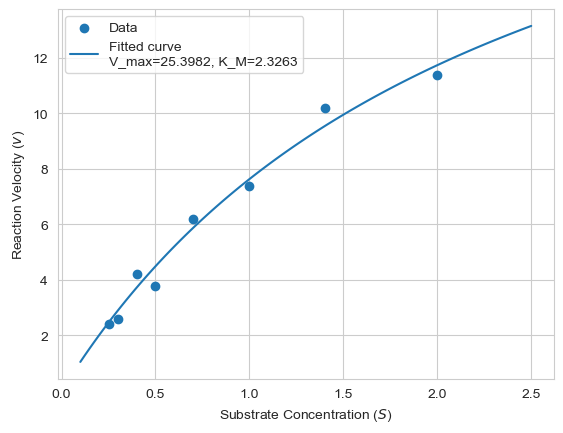

In [37]:
def michaelis_menten(V_max, K_M, S):
    epsilon = 1e-8  # to avoid dividing by 0
    denominator = np.maximum(K_M + S, epsilon)
    result = (V_max * S) / denominator
    return np.clip(result, 0, 1e8)  # to avoid overflow

def error_function(params, S, v):
    V_max, K_M = params
    return np.sum((v - michaelis_menten(V_max, K_M, S))**2)

def gradient(params, S, v):
    epsilon = 1e-8  # to avoid dividing by 0
    V_max, K_M = params
    denominator = np.maximum(K_M + S, epsilon)
    grad_V_max = -2 * np.sum(S * (K_M * v + S * (v - V_max)) / denominator**2)
    grad_K_M = 2 * np.sum(S * V_max * (v - S * V_max / denominator) / denominator**2)
    return np.array([grad_V_max, grad_K_M])

def hessian(params, S, v):
    epsilon = 1e-8  # to avoid dividing by 0
    V_max, K_M = params
    denominator = np.maximum(K_M + S, epsilon)
    H11 = 2 * np.sum((S / denominator)**2)
    H12 = 2 * np.sum(S * (K_M * v + S * (v - 2 * V_max)) / denominator**3)
    H21 = H12
    H22 = 2 * np.sum(2 * S * V_max * (-2 * K_M * v - 2 * S * v + 3 * S * V_max) / denominator**4)
    return np.array([[H11, H12], [H21, H22]])

def golden_section_search(func, params, S, v, tol=1e-5):
    a, b = 0.0, 10.0  
    phi = (np.sqrt(5) - 1) / 2  
    while (b - a) > tol:
        c = b - (b - a) * phi
        d = a + (b - a) * phi
        fc = func(params - c * gradient(params, S, v), S, v)
        fd = func(params - d * gradient(params, S, v), S, v)
        if fc < fd:
            b = d
        elif fc > fd:
            a = c
        else:
            b = d
            a = c
    return (a + b) / 2


def newton_method(S, v, initial_guess, max_iter=100000, tol=1e-15):
    params = initial_guess
    params_array = np.array(params).reshape(2, 1)
    for iteration in range(max_iter):
        grad = gradient(params, S, v)
        H = hessian(params, S, v)

        delta = np.linalg.solve(H, grad)
        step_size = golden_section_search(error_function, params, S, v)
        
        params = params - step_size * delta
        params_array = np.hstack((params_array, np.array(params).reshape(2, 1)))

        if iteration % 100 == 0:
            print(f"Iteration {iteration}:")
            print(f"Parameters: V_max={params[0]}, K_M={params[1]}")
            print(f"Gradient: {grad}")
            print(f"Step size: {step_size}")
        
        if np.linalg.norm(delta) < tol:
            print("Converged!")
            break
    
    return params, params_array

# Data from Wong (1975)
S = np.array([0.25, 0.3, 0.4, 0.5, 0.7, 1.0, 1.4, 2.0]) 
v = np.array([2.4, 2.6, 4.2, 3.8, 6.2, 7.4, 10.2, 11.4])  

initial_guess = [22, 2]

optimal_params, params_array = newton_method(S, v, initial_guess)

V_max_values = params_array[0]
K_M_values = params_array[1]

Vmax_opt, Km_opt = optimal_params
print(f"Optimal V_max: {Vmax_opt:.4f}")
print(f"Optimal K_M: {Km_opt:.4f}")

S_fine = np.linspace(0.1, 2.5, 100)
v_fitted = michaelis_menten(Vmax_opt, Km_opt, S_fine)

plt.scatter(S, v, label="Data")
plt.plot(S_fine, v_fitted, label=f"Fitted curve\nV_max={Vmax_opt:.4f}, K_M={Km_opt:.4f}")
plt.xlabel("Substrate Concentration ($S$)")
plt.ylabel("Reaction Velocity ($v$)")
plt.legend()
plt.show()


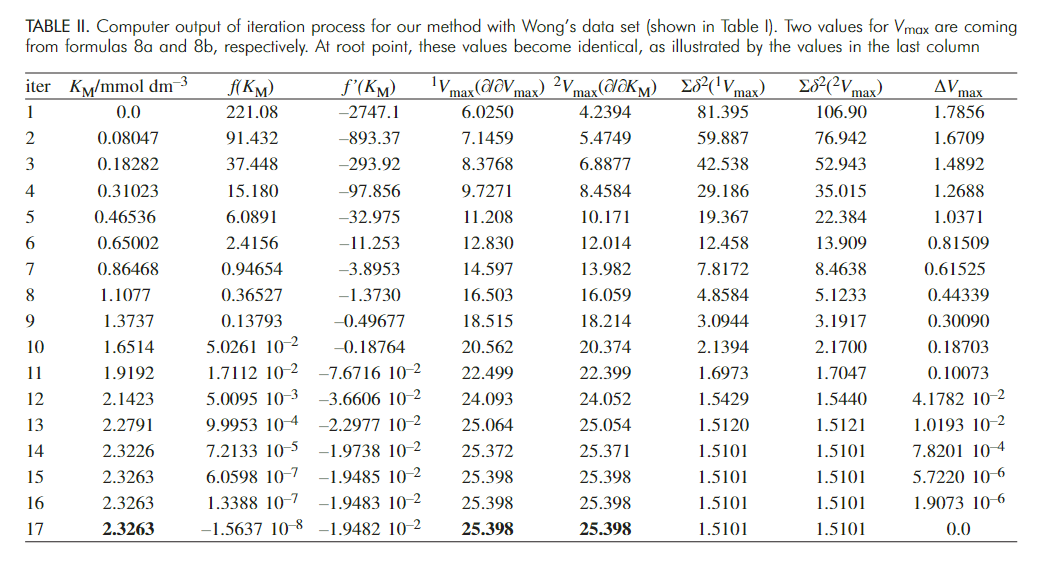